In [1]:
import torch
import torch.nn as nn
import numpy as np
import casadi as ca
import matplotlib.pyplot as plt

<>:46: SyntaxWarning: invalid escape sequence '\o'
<>:46: SyntaxWarning: invalid escape sequence '\o'
C:\Users\lastb\AppData\Local\Temp\ipykernel_20388\4010872162.py:46: SyntaxWarning: invalid escape sequence '\o'
  plt.plot(interval, x1_values, label="Predadores ($\omega$)", color="orange", linewidth=2)
CasADi - 2025-02-05 15:41:39 WARNING("The options 't0', 'tf', 'grid' and 'output_t0' have been deprecated.
The same functionality is provided by providing additional input arguments to the 'integrator' function, in particular:
 * Call integrator(..., t0, tf, options) for a single output time, or
 * Call integrator(..., t0, grid, options) for multiple grid points.
The legacy 'output_t0' option can be emulated by including or excluding 't0' in 'grid'.
Backwards compatibility is provided in this release only.") [.../casadi/core/integrator.cpp:515]


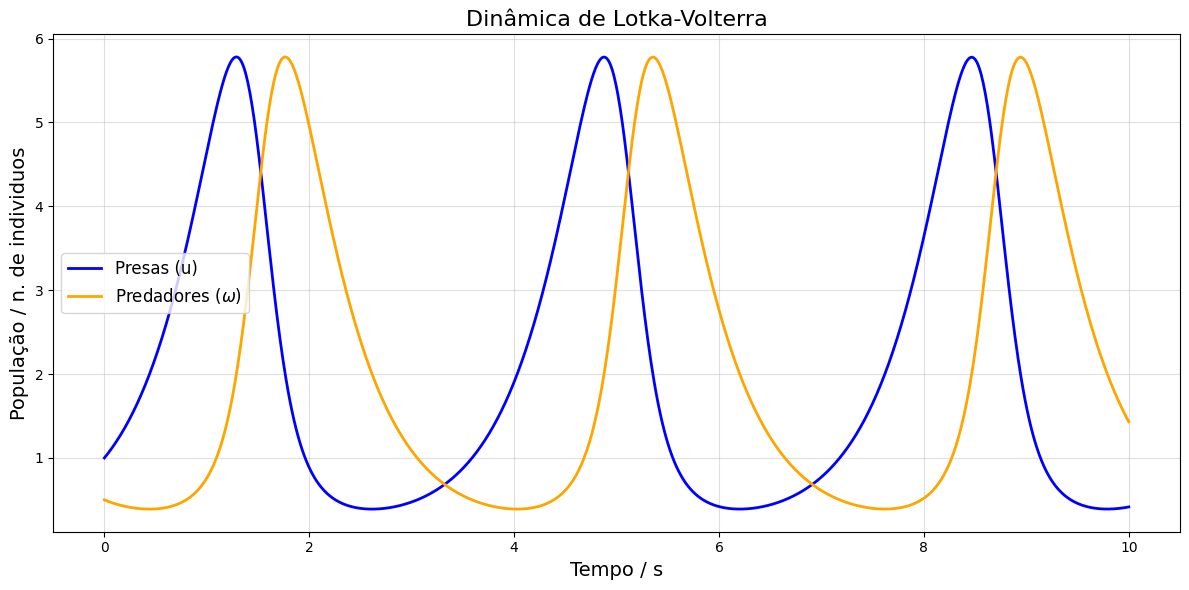

In [2]:
# Intervalo de tempo refinado
interval = np.linspace(0, 10, 1000)  # 1000 pontos no tempo
x0_values = []
x1_values = []

# Definição do modelo Lotka-Volterra
x = ca.MX.sym('x', 2)
alpha = 2.0
beta = 1.0
delta = 1.0
gamma = 2.0

rhs = ca.vertcat(alpha * x[0] - beta * x[0] * x[1],
                 delta * x[0] * x[1] - gamma * x[1])

ode = {'x': x, 'ode': rhs}

# Criar integrador com passo de tempo
dt = interval[1] - interval[0]
F = ca.integrator('F', 'cvodes', ode, {'tf': dt})

# Condições iniciais
x0 = [1.0, 0.5]  # u(0) = 1.0, v(0) = 0.5
x0_values.append(x0[0])
x1_values.append(x0[1])

# Iterar sobre o intervalo
for t in range(len(interval) - 1):
    sol = F(x0=x0)  # Solução para o próximo passo
    xf_values = np.array(sol["xf"]).flatten()
    x0_values.append(xf_values[0])  # Adiciona u(t)
    x1_values.append(xf_values[1])  # Adiciona v(t)
    x0 = xf_values  # Atualiza condições iniciais para o próximo passo

# Transformar em arrays NumPy
x0_values = np.array(x0_values)
x1_values = np.array(x1_values)

# Plotar os resultados
plt.figure(figsize=(12, 6))

# População de presas
plt.plot(interval, x0_values, label="Presas (u)", color="blue", linewidth=2)

# População de predadores
plt.plot(interval, x1_values, label="Predadores ($\omega$)", color="orange", linewidth=2)

# Configurações do gráfico
plt.title("Dinâmica de Lotka-Volterra", fontsize=16)
plt.xlabel("Tempo / s", fontsize=14)
plt.ylabel("População / n. de individuos", fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()
# Gerar dados (usando o código anterior)
np.savez("lotka_volterra_data.npz", t=interval, u=x0_values, v=x1_values)


In [35]:
import torch
import torch.nn as nn
import random
import math
from tqdm import tqdm
import matplotlib.pyplot as plt
import copy

# Classe PINN com pruning aplicado corretamente em todas as camadas
class PINN(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=200, output_dim=2, num_layers=4):
        super(PINN, self).__init__()
        self.hidden_dim = hidden_dim
        layers = []
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.LeakyReLU())

        for _ in range(num_layers - 2):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.LeakyReLU())

        layers.append(nn.Linear(hidden_dim, output_dim))
        self.layers = nn.Sequential(*layers)

    def forward(self, t):
        return self.layers(t)

    def prune_neurons(self, prune_threshold=0.1):
        for i, layer in enumerate(self.layers):
            if isinstance(layer, nn.Linear):
                # Pruning nos pesos
                weight_mask = torch.abs(layer.weight.data) > prune_threshold
                layer.weight.data *= weight_mask.float()

            # Verifica quais neurônios têm todos os pesos podados
                neurons_to_prune = torch.all(weight_mask == 0, dim=1)

            # Podar os vieses correspondentes aos neurônios podados
                if layer.bias is not None:
                    layer.bias.data[neurons_to_prune] = 0

    def count_active_neurons(self, prune_threshold=0.1):
        """ Conta quantos neurônios estão ativos em todas as camadas """
        active_counts = []
        total_active = 0

        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                weight_abs = torch.abs(layer.weight.data)
                active_neurons = (weight_abs > prune_threshold).any(dim=1)
                count = torch.sum(active_neurons).item()
                active_counts.append(count)
                total_active += count

        return active_counts, total_active

# Função de perda
def loss_pinn(model, t_train, u_train, v_train, alpha, beta, delta, gamma):
    t_train.requires_grad = True
    uv_pred = model(t_train)
    u_pred, v_pred = uv_pred[:, 0], uv_pred[:, 1]

    data_loss = torch.mean((u_pred - u_train) ** 2 + (v_pred - v_train) ** 2)

    u_t = torch.autograd.grad(u_pred, t_train, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0]
    v_t = torch.autograd.grad(v_pred, t_train, grad_outputs=torch.ones_like(v_pred), create_graph=True)[0]
    eq1 = u_t - (alpha * u_pred - beta * u_pred * v_pred)
    eq2 = v_t - (delta * u_pred * v_pred - gamma * v_pred)
    physics_loss = torch.mean(eq1 ** 2 + eq2 ** 2)

    return data_loss + 1E-3 * physics_loss

# Função de Simulated Annealing com pruning atualizado
def simulated_annealing_with_pruning(
    model, t_train, u_train, v_train, alpha, beta, delta, gamma,
    T_init=1.0, T_min=0.001, eta=0.87, MLL=200, prune_interval=200, prune_threshold=0.1
    ):
    T = T_init
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_loss = float('inf')
    best_model = copy.deepcopy(model.state_dict())
    loss_history = []

    with tqdm(total=int((T_init - T_min) / (T_init * (1 - eta))), desc="Simulated Annealing") as pbar_outer:
        while T > T_min:
            with tqdm(total=MLL, desc=f"Temperatura: {T:.4f}", leave=False) as pbar_inner:
                for step in range(MLL):
                    loss = loss_pinn(model, t_train, u_train, v_train, alpha, beta, delta, gamma)
                    loss_history.append(loss.item())

                    temp_model = copy.deepcopy(model)
                    temp_model.load_state_dict(model.state_dict())

                    with torch.no_grad():
                        for param in temp_model.parameters():
                            param.add_(T * torch.randn_like(param))

                    new_loss = loss_pinn(temp_model, t_train, u_train, v_train, alpha, beta, delta, gamma)

                    if new_loss < loss or math.exp((loss - new_loss) / T) > random.random():
                        model.load_state_dict(temp_model.state_dict())
                        loss = new_loss

                    if loss < best_loss:
                        best_loss = loss
                        best_model = copy.deepcopy(model.state_dict())

                    if step % prune_interval == 0:
                        model.prune_neurons(prune_threshold)

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    pbar_inner.set_postfix(loss=loss.item())
                    pbar_inner.update(1)

            T *= eta
            pbar_outer.update(1)

    model.load_state_dict(best_model)
    return model, loss_history

# Função para plotar a loss
def plot_loss(loss_history):
    plt.figure(figsize=(10, 6))
    plt.plot(loss_history, label="Loss")
    plt.xlabel("Iteração")
    plt.ylabel("Loss")
    plt.title("Evolução da Loss durante o Simulated Annealing")
    plt.legend()
    plt.grid(True)
    plt.show()

In [32]:
# Carregar os dados
data = np.load("lotka_volterra_data.npz")
t_data = torch.tensor(data["t"], dtype=torch.float32).unsqueeze(1)  # Domínio temporal
u_data = torch.tensor(data["u"], dtype=torch.float32)  # Valores de u(t)
v_data = torch.tensor(data["v"], dtype=torch.float32)  # Valores de v(t)


model = PINN()

# Executar Simulated Annealing com pruning
model, loss_history = simulated_annealing_with_pruning(
    model, t_data, u_data, v_data, alpha, beta, delta, gamma
)

# Plotar a loss
plot_loss(loss_history)


Simulated Annealing: 14it [02:40, 11.18s/it]                      

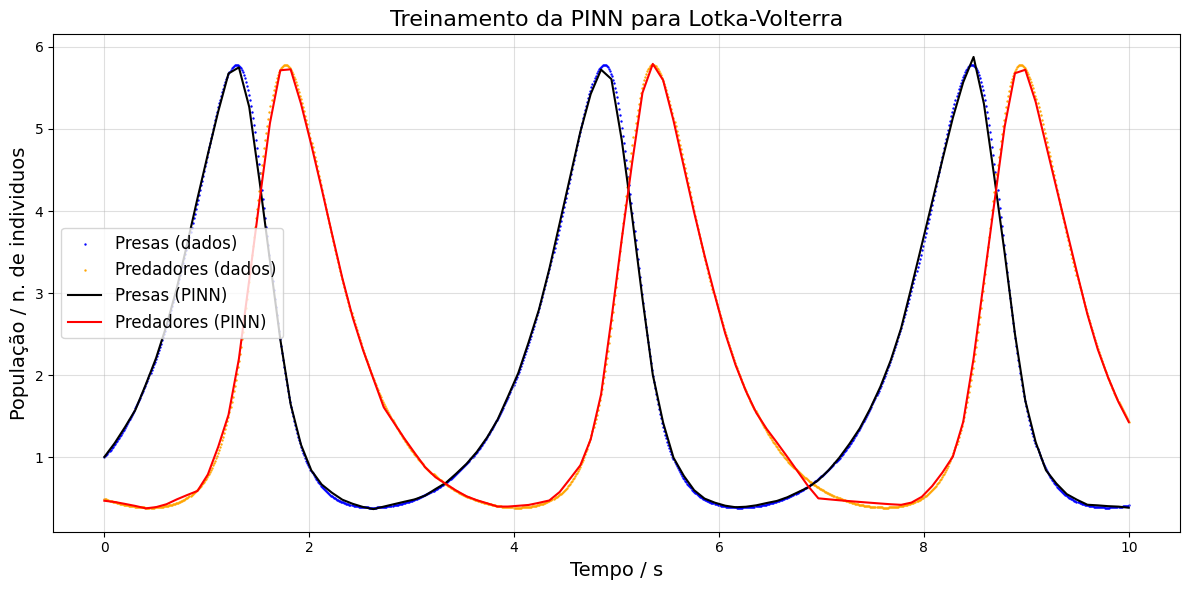

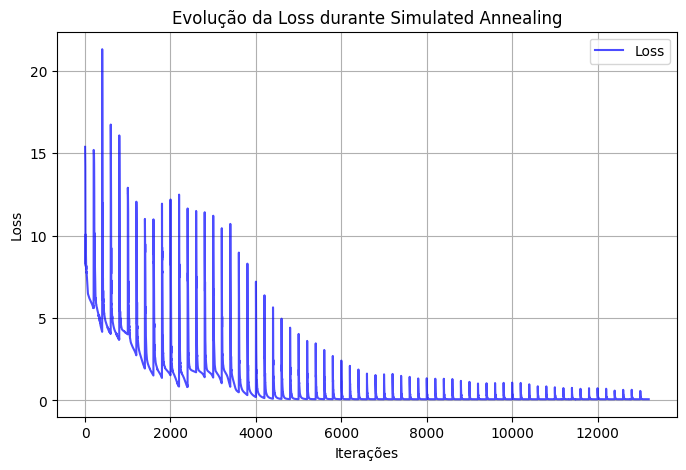

In [33]:
# Criar 100 pontos uniformemente espaçados para avaliação
t_test = torch.linspace(t_data.min(), t_data.max(), 100).unsqueeze(1)

# Fazer previsões com a PINN
uv_pred = model(t_test).detach().numpy()
u_pred, v_pred = uv_pred[:, 0], uv_pred[:, 1]

# Plotar os resultados
plt.figure(figsize=(12, 6))

# Dados reais (10 pontos de treinamento)
plt.scatter(data["t"], data["u"], label="Presas (dados)", color="blue", s=0.5, marker='o')
plt.scatter(data["t"], data["v"], label="Predadores (dados)", color="orange", s=0.5, marker='o')

# Previsões da PINN (100 pontos)
plt.plot(t_test.numpy(), u_pred, label="Presas (PINN)", color="black", linestyle="-")
plt.plot(t_test.numpy(), v_pred, label="Predadores (PINN)", color="red", linestyle="-")

plt.title("Treinamento da PINN para Lotka-Volterra", fontsize=16)
plt.xlabel("Tempo / s", fontsize=14)
plt.ylabel("População / n. de individuos", fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(loss_history, label="Loss", color="blue", alpha=0.7)
plt.xlabel("Iterações")
plt.ylabel("Loss")
plt.title("Evolução da Loss durante Simulated Annealing")
plt.legend()
plt.grid(True)
plt.show()


In [34]:
active_neurons_per_layer, total_active_neurons = model.count_active_neurons()
print(f"Neurônios ativos por camada: {active_neurons_per_layer}")
print(f"Total de neurônios ativos: {total_active_neurons}")

Neurônios ativos por camada: [79, 200, 198, 2]
Total de neurônios ativos: 479
